In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm


In [7]:


meta_data = pd.read_parquet("./Energy-graph/data/energy-forecast/data/processed/refit_metadata.parquet")

df = pd.read_parquet("./Energy-graph/data/energy-forecast/data/refit-dataset-hourly.parquet")


In [6]:
store = pd.HDFStore('./datasets/NILM/refit.h5', "r")
".."
# This will print the keys of all datasets in the HDF5 file
print(store.keys())
store.close()

['/building9/elec/meter1', '/building9/elec/meter10', '/building9/elec/meter2', '/building9/elec/meter3', '/building9/elec/meter4', '/building9/elec/meter5', '/building9/elec/meter6', '/building9/elec/meter7', '/building9/elec/meter8', '/building9/elec/meter9', '/building9/elec/cache/meter9/total_energy', '/building9/elec/cache/meter8/good_sections', '/building9/elec/cache/meter8/total_energy', '/building9/elec/cache/meter7/good_sections', '/building9/elec/cache/meter7/total_energy', '/building9/elec/cache/meter6/good_sections', '/building9/elec/cache/meter6/total_energy', '/building9/elec/cache/meter5/good_sections', '/building9/elec/cache/meter5/total_energy', '/building9/elec/cache/meter4/good_sections', '/building9/elec/cache/meter4/total_energy', '/building9/elec/cache/meter3/total_energy', '/building9/elec/cache/meter2/good_sections', '/building9/elec/cache/meter2/total_energy', '/building9/elec/cache/meter10/total_energy', '/building8/elec/meter1', '/building8/elec/meter10', '/b

In [9]:
df[df["house"]== 2].columns

# remove metadata
df.drop(columns=['occupancy', 'construction_year',
       'appliances_owned', 'house_type', 'house_size', 'country', 'location',
       'lat', 'lon', 'tz', 'appliances', 'is_holiday', 'weekday', 'is_weekend',
       'day_percent', 'week_percent', 'year_percent', 'solar_altitude',
       'solar_azimuth', 'solar_radiation'], inplace=True)

df.head()   



,aggregate,appliance1,appliance2,appliance3,appliance4,appliance5,appliance6,appliance7,appliance8,appliance9,timestamp,house
0,862.651528,15.699167,16.796389,2.612917,0.000000,0.0,0.0,0.0,0.000000,0.895000,2013-10-09 14:00:00+01:00,1
1,648.943889,1.560417,17.402639,40.684861,0.000000,0.0,0.0,0.0,0.000000,1.000000,2013-10-09 15:00:00+01:00,1
2,595.499722,35.210556,16.401250,38.263472,0.000000,0.0,0.0,0.0,0.000000,1.000000,2013-10-09 16:00:00+01:00,1
3,289.313056,0.805694,16.545278,8.908750,0.000000,0.0,0.0,0.0,0.000000,0.995278,2013-10-09 17:00:00+01:00,1
4,305.902778,36.058889,20.559306,34.558611,0.016667,0.0,0.0,0.0,29.808889,1.000000,2013-10-09 18:00:00+01:00,1


In [74]:

appliances = [
        'aggregate, fridge, chest freezer, upright freezer, tumble dryer, washing machine, dishwasher, computer site, television site, electric heater',
        'aggregate, fridge-freezer, washing machine, dishwasher, television, microwave, toaster, hi-fi, kettle, oven extractor fan',
        'aggregate, toaster, fridge-freezer, freezer, tumble dryer, dishwasher, washing machine, television, microwave, kettle',
        'aggregate, fridge, freezer, fridge-freezer, washing machine (1), washing machine (2), computer site, television site, microwave, kettle',
        'aggregate, fridge-freezer, tumble dryer 3, washing machine, dishwasher, computer site, television site, combination microwave, kettle, toaster',
        'aggregate, freezer (utility room), washing machine, dishwasher, mjy computer, television site, microwave, kettle, toaster, pgm computer',
        'aggregate, fridge, freezer (garage), freezer, tumble dryer, washing machine, dishwasher, television site, toaster, kettle',
        'aggregate, fridge, freezer, dryer, washing machine, toaster, computer, television site, microwave, kettle',
        'aggregate, fridge-freezer, washer dryer, washing machine, dishwasher, television site, microwave, kettle, hi-fi, electric heater',
        'aggregate, magimix (blender), freezer, chest freezer (in garage), fridge-freezer, washing machine, dishwasher, television site, microwave, kenwood kmix',
        'aggregate, fridge, fridge-freezer, washing machine, dishwasher, computer site, microwave, kettle, router, hi-fi',
        'aggregate, fridge-freezer, television site(lounge), microwave, kettle, toaster, television site (bedroom), not used, not used, not used',
        'aggregate, television site, unknown, washing machine, dishwasher, tumble dryer, television site, computer site, microwave, kettle',
        None,
        'aggregate, fridge-freezer, tumble dryer, washing machine, dishwasher, computer site, television site, microwave, kettle, toaster',
        'aggregate, fridge-freezer (1), fridge-freezer (2), electric heater (1)?, electric heater (2), washing machine, dishwasher, computer site, television site, dehumidifier/heater',
        'aggregate, freezer (garage), fridge-freezer, tumble dryer (garage), washing machine, computer site, television site, microwave, kettle, plug site (bedroom)',
        'aggregate, fridge(garage), freezer(garage), fridge-freezer, washer dryer(garage), washing machine, dishwasher, desktop computer, television site, microwave',
        'aggregate, fridge & freezer, washing machine, television site, microwave, kettle, toaster, bread-maker, lamp (80watts), hi-fi',
        'aggregate, fridge, freezer, tumble dryer, washing machine, dishwasher, computer site, television site, microwave, kettle',
        'aggregate, fridge-freezer, tumble dryer, washing machine, dishwasher, food mixer, television, kettle/toaster, vivarium, pond pump',
]

# renames columns to appliance names and returns a list of dataframes where index is house number
def rename_columns(df: pd.DataFrame) -> list:

    house_dfs = []
    for house in tqdm(df["house"].unique()):
        house_df = df[df["house"] == house].copy()
        house_df.drop(columns=["house"], inplace=True)
        house_df /= 1000 # convert to kWh
        device_names = appliances[house-1].split(",")
        if device_names != None:
            house_df.columns = appliances[house-1].split(",")
            
        house_dfs.append(house_df)
    return house_dfs


def calculate_loadprofiles(df: pd.DataFrame) -> dict:
    daily = df.resample("D").sum()
    
    loadprofiles = {}
    for column in tqdm(df.columns):
        

        lp_daily = df[column].groupby(df[column].index.hour).mean().values
        lp_weekly = daily[column].groupby(daily[column].index.dayofweek).mean().values
        lp_monthly = daily[column].groupby(daily[column].index.day).mean().values


        loadprofiles[column] = {
            "daily": lp_daily,
            "weekly": lp_weekly,
            "monthly": lp_monthly,
        }


    return loadprofiles
        



            

In [84]:
test_df = df.copy()

houses_df = rename_columns(test_df)

# iterate over houses and calculate loadprofiles and also have index
loadprofiles = {}
for i,house in enumerate(houses_df):
    loadprofiles[i+1] = calculate_loadprofiles(house)



100%|██████████| 10/10 [00:00<00:00, 636.13it/s]


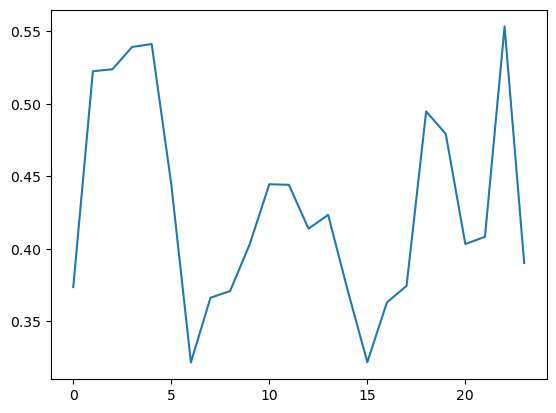

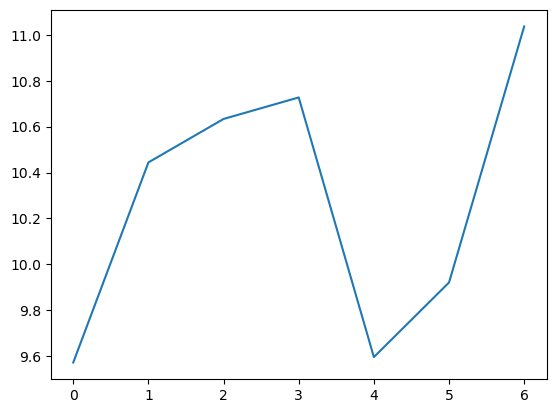

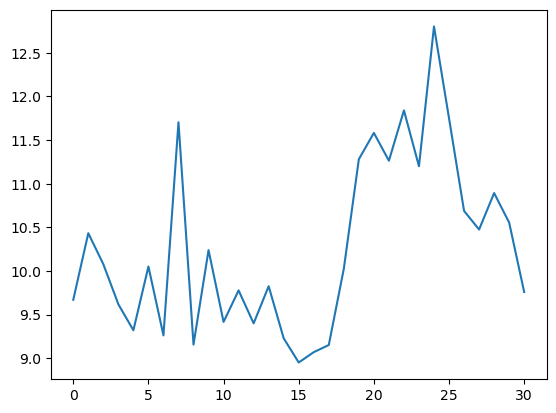

In [89]:
plt.plot(loadprofiles[1]["aggregate"]["daily"], label="daily")
plt.show()
plt.plot(loadprofiles[1]["aggregate"]["weekly"], label="weekly")
plt.show()
plt.plot(loadprofiles[1]["aggregate"]["monthly"], label="monthly")
plt.show()

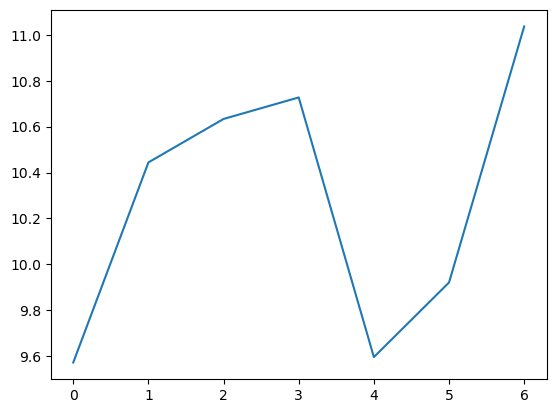

In [77]:
plt.plot(lp["aggregate"]["weekly"])

In [10]:
df.set_index("timestamp", inplace=True)

In [11]:
df.head()

,aggregate,appliance1,appliance2,appliance3,appliance4,appliance5,appliance6,appliance7,appliance8,appliance9,house
timestamp,,,,,,,,,,,
2013-10-09 14:00:00+01:00,862.651528,15.699167,16.796389,2.612917,0.000000,0.0,0.0,0.0,0.000000,0.895000,1
2013-10-09 15:00:00+01:00,648.943889,1.560417,17.402639,40.684861,0.000000,0.0,0.0,0.0,0.000000,1.000000,1
2013-10-09 16:00:00+01:00,595.499722,35.210556,16.401250,38.263472,0.000000,0.0,0.0,0.0,0.000000,1.000000,1
2013-10-09 17:00:00+01:00,289.313056,0.805694,16.545278,8.908750,0.000000,0.0,0.0,0.0,0.000000,0.995278,1
2013-10-09 18:00:00+01:00,305.902778,36.058889,20.559306,34.558611,0.016667,0.0,0.0,0.0,29.808889,1.000000,1
